# Pretrain results summary

This notebook pulls specific W&B runs and compiles requested metrics into a table.

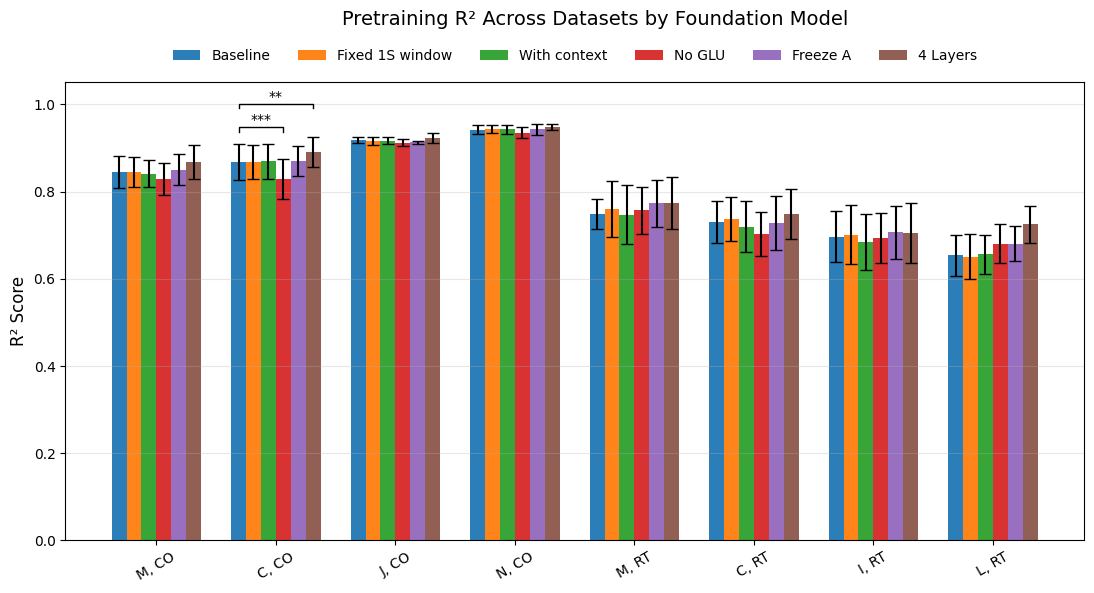

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
import wandb
import os
from scipy.stats import ttest_ind
import pandas as pd
from foundational_ssm.models import SSMDownstreamDecoder

# Helper to safely extract nested config or summary keys

def get_summary_value(run, key):
    try:
        return run.summary.get(key, None)
    except Exception:
        return None

def benjamini_hochberg(pvals):
    m = len(pvals)
    if m == 0:
        return []
    order = np.argsort(pvals)
    ranked = np.array(pvals)[order]
    q = np.empty(m)
    prev = 1.0
    for k in range(m - 1, -1, -1):
        qk = ranked[k] * m / (k + 1)
        prev = min(prev, qk)
        q[k] = prev
    q_adj = np.empty(m)
    q_adj[order] = q
    return list(q_adj)


def star_from_p(p):
    if p < 1e-3:
        return '***'
    if p < 1e-2:
        return '**'
    if p < 0.05:
        return '*'
    return ''


def annotate_pair(ax, x1, x2, y, text, height=0.01, linewidth=1.0):
    if x2 < x1:
        x1, x2 = x2, x1
    ax.plot([x1, x1, x2, x2], [y, y + height, y + height, y], lw=linewidth, c='k')
    ax.text((x1 + x2) / 2, y + height, text, ha='center', va='bottom', fontsize=10)

# --- New factorized helpers ---
def gather_run_samples(api, project, run_display_by_label):
    """Return dict: pretty_label -> list of finished wandb.Run objects."""
    out = {}
    for label, display_name in run_display_by_label.items():
        try:
            runs = api.runs(project, filters={"display_name": display_name})
        except Exception:
            runs = []
        out[label] = list(runs)
    return out

def extract_per_recording_values(run, ds_key):
    """Collect per-recording summary values under val/r2/{ds_key}/<recording_id> and skip mean/std.
    Falls back to mean if none found for this run."""
    prefix = f"val/r2/{ds_key}/"
    vals = []
    try:
        for k, v in getattr(run, 'summary', {}).items():
            if isinstance(k, str) and k.startswith(prefix):
                suffix = k[len(prefix):]
                if suffix in ("mean", "std"):
                    continue
                try:
                    if v is not None:
                        vals.append(float(v))
                except Exception:
                    pass
        if len(vals) == 0:
            mv = run.summary.get(f"val/r2/{ds_key}/mean", None)
            if mv is not None:
                vals.append(float(mv))
    except Exception:
        pass
    return vals

def build_samples_per_model(run_samples, ds_key, results_df, run_display_by_label):
    """Return dict: pretty_label -> np.ndarray of pooled per-recording values across finished runs.
    If none found for a label, falls back to results_df mean (single value) when available."""
    samples = {}
    for label in run_display_by_label.keys():
        vals = []
        for r in run_samples.get(label, []):
            vals.extend(extract_per_recording_values(r, ds_key))
        if len(vals) == 0:
            try:
                row = results_df[results_df['run'] == run_display_by_label[label]].iloc[0]
                val = row.get(f"val/r2/{ds_key}/mean", None)
                if val is not None:
                    vals = [float(val)]
            except Exception:
                pass
        if len(vals):
            samples[label] = np.asarray(vals, dtype=float)
    return samples

def annotate_significance_pairs(ax, j, samples, label_order, x, offsets, bar_tops, baseline_label='Baseline'):
    """Welch t-tests: only Baseline vs every other available label (BH corrected)."""
    if baseline_label not in samples:
        return
    others = [lbl for lbl in label_order if lbl in samples and lbl != baseline_label]
    pair_labels = [(baseline_label, lbl) for lbl in others]
    if not pair_labels:
        return
    raw_p = []
    for a, b in pair_labels:
        try:
            _, p = ttest_ind(samples[a], samples[b], equal_var=False, nan_policy='omit')
        except Exception:
            p = 1.0
        raw_p.append(float(p) if p is not None else 1.0)
    adj_p = benjamini_hochberg(raw_p)
    level = 0
    for (a, b), p_adj in zip(pair_labels, adj_p):
        stars = star_from_p(p_adj)
        if not stars:
            continue
        ia = label_order.index(a)
        ib = label_order.index(b)
        x1 = (x + offsets[ia])[j]
        x2 = (x + offsets[ib])[j]
        base = max(bar_tops.get((j, a), 0), bar_tops.get((j, b), 0))
        y = base + 0.07 + level * 0.03
        annotate_pair(ax, x1, x2, y, stars)
        level += 1
    return

PROJECT = "melinajingting-ucl/foundational_ssm_pretrain"
RUN_DISPLAY_BY_LABEL = {
    "Baseline": "l2_reaching",
    "Fixed 1S window": "l2_with_context_reaching_1Swindow",
    "With context": "l2_with_context_reaching",
    "No GLU": "l2_no_glu_reaching",
    "Freeze A": "l2_freeze_a_reaching",
    "4 Layers": "l4_reaching",
}
DATASETS = {
    "M, CO": "pm_m_co",
    "C, CO": "pm_c_co",
    "J, CO": "cs_j_co",
    "N, CO": "cs_n_co",
    "M, RT": "pm_m_rt",
    "C, RT": "pm_c_rt",
    "I, RT": "os_i_rt",
    "L, RT": "os_l_rt",
}
ALL_KEY = "val/r2/all"
MEAN_KEY = "val/r2/{ds}/mean"
STD_KEY = "val/r2/{ds}/std"

# Helpers
RUN_LABELS = list(RUN_DISPLAY_BY_LABEL.keys())                   # pretty labels
DATASET_LABELS = list(DATASETS.keys())
DATASET_KEYS = [DATASETS[k] for k in DATASET_LABELS]    # preserve label order


api_key = os.environ.get("WANDB_API_KEY")
api = wandb.Api()


rows = []
for run_pretty, run_name in RUN_DISPLAY_BY_LABEL.items():
    # Select by run display name; if duplicate names exist, take the latest finished
    runs = api.runs(PROJECT, filters={"display_name": run_name})
    run = None
    if runs:
        # Prefer finished runs; else take the first
        finished = [r for r in runs if r.state == "finished"]
        run = finished[0] if finished else runs[0]
    if run is None:
        rows.append({"run": run_name, "error": "not found"})
        continue

    row = {"run": run_name}
    # All metric
    row[ALL_KEY] = get_summary_value(run, ALL_KEY)
    # Dataset metrics
    for ds_pretty, ds in DATASETS.items():
        row[MEAN_KEY.format(ds=ds)] = get_summary_value(run, MEAN_KEY.format(ds=ds))
        row[STD_KEY.format(ds=ds)] = get_summary_value(run, STD_KEY.format(ds=ds))
    rows.append(row)

results_df = pd.DataFrame(rows)
# Order columns: run, all, then dataset means/stds in requested order
cols = ["run", ALL_KEY]
for ds_pretty, ds in DATASETS.items():
    cols += [MEAN_KEY.format(ds=ds), STD_KEY.format(ds=ds)]
results_df = results_df.reindex(columns=cols)

# Collect finished runs per pretty label for significance sampling
run_samples = gather_run_samples(api, PROJECT, RUN_DISPLAY_BY_LABEL)

# Plot grouped bars per dataset with models (RUN_LABELS) as groups within each dataset
plt.figure(figsize=(12, 6))
x = np.arange(len(DATASET_LABELS))
C = len(RUN_LABELS)
width = min(0.75 / max(C, 1), 0.22)
offsets = (np.arange(C) - (C - 1) / 2.0) * width
colors = plt.cm.tab10.colors
model_colors = {label: colors[i % len(colors)] for i, label in enumerate(RUN_LABELS)}

bar_tops = {}  # (ds_idx, label) -> top y value
for i, (pretty_label, run_name) in enumerate(RUN_DISPLAY_BY_LABEL.items()):
    means = results_df[results_df['run'] == run_name][[MEAN_KEY.format(ds=ds_key) for ds_key in DATASET_KEYS]].values.flatten()
    stds = results_df[results_df['run'] == run_name][[STD_KEY.format(ds=ds_key) for ds_key in DATASET_KEYS]].values.flatten()
    bars = plt.bar(x + offsets[i], means, width=width, yerr=stds, capsize=4, alpha=0.95, label=pretty_label, color=model_colors[pretty_label])
    for j, b in enumerate(bars):
        bar_tops[(j, pretty_label)] = b.get_height()


ax = plt.gca()
max_height_by_ds = {j: 0.0 for j in range(len(DATASET_LABELS))}
for j, ds_key in enumerate(DATASET_KEYS):
    # Build samples per model for this dataset using per-recording values with fallback
    samples = build_samples_per_model(run_samples, ds_key, results_df, RUN_DISPLAY_BY_LABEL)
    # Annotate significance: Baseline vs each other model
    annotate_significance_pairs(ax, j, samples, RUN_LABELS, x, offsets, bar_tops, baseline_label='Baseline')

# Labels and legend
plt.xticks(x, DATASET_LABELS, rotation=30)
plt.ylabel('R² Score', fontsize=12)
# Legend at top using pretty run labels
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=6, frameon=False)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout(rect=[0, 0, 0.92, 0.95])
plt.suptitle('Pretraining R² Across Datasets by Foundation Model', fontsize=14)
plt.show()

## Downstream sweep results (wandb: foundational_ssm_downstream_sweep)

Fetch finished runs, extract `final/r2/*/mean`, aggregate per dataset/task across configurations, and plot comparisons.

In [3]:
# Fetch downstream sweep runs and extract final metrics
import re
from collections import defaultdict
import pandas as pd

DOWNSTREAM_PROJECT = "melinajingting-ucl/foundational_ssm_downstream_sweep"

api = wandb.Api()
runs = api.runs(DOWNSTREAM_PROJECT, filters={"state": "finished"})

records = []
for r in runs:
    cfg = r.config or {}
    # Extract sweep origin if present
    sweep_name = r.sweep.name if getattr(r, "sweep", None) else None
    # Find all final/r2/*/mean in summary
    for k, v in r.summary.items():
        if isinstance(k, str) and k.startswith("final/r2/") and k.endswith("/mean"):
            dataset = k[len("final/r2/"):-len("/mean")]
            records.append({
                "run_id": r.id,
                "run_name": r.display_name,
                "sweep": sweep_name,
                "dataset": dataset,
                "r2": v,
                # Key config axes for comparisons
                "from_scratch": cfg.get("training.from_scratch"),
                "opt_mode": cfg.get("optimizer.mode"),  # all vs encoder_only
                "checkpoint": cfg.get("model.checkpoint"),
                "dataset_name": cfg.get("dataset.name") or cfg.get("dataset_args.recording_id"),
            })

downstream_df = pd.DataFrame.from_records(records)
downstream_df.head()

,run_id,run_name,sweep,dataset,r2,from_scratch,opt_mode,checkpoint,dataset_name
0,koxc3s3i,scratch_l2_reaching_mc_rtt_prepend_all,official_transfer_sweep_2sep,mc_rtt_prepend,0.742570,True,all,melinajingting-ucl/foundational_ssm_pretrain/l...,mc_rtt_prepend
1,gigzarb9,finetuned_l2_reaching_mc_rtt_prepend_all,official_transfer_sweep_2sep,mc_rtt_prepend,0.756788,False,all,melinajingting-ucl/foundational_ssm_pretrain/l...,mc_rtt_prepend
2,jjtyfpud,scratch_l2_reaching_mc_rtt_prepend_encoder_only,official_transfer_sweep_2sep,mc_rtt_prepend,0.011309,True,encoder_only,melinajingting-ucl/foundational_ssm_pretrain/l...,mc_rtt_prepend
3,bh9j06qf,finetuned_l2_reaching_mc_rtt_prepend_encoder_only,official_transfer_sweep_2sep,mc_rtt_prepend,0.057567,False,encoder_only,melinajingting-ucl/foundational_ssm_pretrain/l...,mc_rtt_prepend
4,jzbavaqw,scratch_l2_reaching_1Swindow_mc_rtt_prepend_all,official_transfer_sweep_2sep,mc_rtt_prepend,0.742570,True,all,melinajingting-ucl/foundational_ssm_pretrain/l...,mc_rtt_prepend


In [4]:
# Identify PM vs NLB datasets and compute aggregates for PM tasks

def is_pm(dataset: str) -> bool:
    return isinstance(dataset, str) and (dataset.startswith("pm_") or "perich_miller" in dataset or dataset.startswith("t_"))


def pm_task_from_dataset(ds: str) -> str:
    # Handle multiple naming styles:
    # - pm_* suffixes: *_co -> center_out, *_rt -> random_target
    # - recording ids like t_YYYYMMDD_center_out_reaching / random_target_reaching
    if not isinstance(ds, str):
        return "unknown"
    if ds.endswith("_co") or "center_out_reaching" in ds:
        return "pm_center_out"
    if ds.endswith("_rt") or "random_target_reaching" in ds:
        return "pm_random_target"
    return ds  # fallback to original label

# Build a tidy base dataframe per run/dataset with a derived task column
plot_df = downstream_df.copy()
plot_df["is_pm"] = plot_df["dataset"].apply(is_pm)
plot_df["task"] = plot_df.apply(
    lambda x: pm_task_from_dataset(x["dataset"]) if x["is_pm"] else x["dataset"], axis=1
)

# Friendly labels for plotting
plot_df["train_mode"] = plot_df["from_scratch"].map({True: "scratch", False: "finetune"}).fillna("unknown")
plot_df["checkpoint_short"] = plot_df["checkpoint"].apply(
    lambda s: s.split("/")[-1].split(":")[0] if isinstance(s, str) else s
)

# Aggregated (mean/std) per (checkpoint, train_mode, opt_mode, task)
agg_cols = ["checkpoint_short", "train_mode", "opt_mode", "task"]
pm_agg = (
    plot_df[plot_df["is_pm"]]
    .groupby(agg_cols)
    .agg(r2_mean=("r2", "mean"), r2_std=("r2", "std"), n=("r2", "count"))
    .reset_index()
)

nlb_agg = (
    plot_df[~plot_df["is_pm"]]
    .groupby(agg_cols)
    .agg(r2_mean=("r2", "mean"), r2_std=("r2", "std"), n=("r2", "count"))
    .reset_index()
)

agg_df = pd.concat([pm_agg, nlb_agg], ignore_index=True, sort=False)
agg_df.head()

,checkpoint_short,train_mode,opt_mode,task,r2_mean,r2_std,n
0,l2_no_context_reaching_checkpoint,finetune,all,pm_center_out,0.810766,0.043753,6
1,l2_no_context_reaching_checkpoint,finetune,all,pm_random_target,0.444752,0.219016,6
2,l2_no_context_reaching_checkpoint,finetune,encoder_only,pm_center_out,0.686614,0.069142,6
3,l2_no_context_reaching_checkpoint,finetune,encoder_only,pm_random_target,0.321879,0.201404,6
4,l2_no_context_reaching_checkpoint,scratch,all,pm_center_out,0.861029,0.025407,6


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t as student_t
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


def bh_adjust(pvals):
    m = len(pvals)
    if m == 0:
        return []
    order = np.argsort(pvals)
    ranked = np.array(pvals)[order]
    q = np.empty(m)
    prev = 1.0
    for k in range(m - 1, -1, -1):
        qk = ranked[k] * m / (k + 1)
        prev = min(prev, qk)
        q[k] = prev
    out = np.empty(m)
    out[order] = q
    return out.tolist()

def p_to_stars(p):
    if p < 1e-3:
        return '***'
    if p < 1e-2:
        return '**'
    if p < 0.05:
        return '*'
    return ''

def annotate(ax, x1, x2, y, text, h=0.01, lw=1.0):
    if x2 < x1:
        x1, x2 = x2, x1
    ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=lw, c='k')
    ax.text((x1 + x2) / 2, y + h, text, ha='center', va='bottom', fontsize=10)

# Targets and order
SUBPLOT_TASKS = ["mc_rtt_prepend", "pm_center_out", "mc_area2bump_prepend"]
TRAIN_MODE_ORDER = ["finetune", "scratch"]
TRAIN_MODE_LABEL = {"finetune": "Finetune", "scratch": "Scratch"}
HATCHES = {"scratch": "\\\\"}  # finetune solid (no hatch)

# Color per checkpoint_short, harmonized to pretraining model colors
model_color_cycle = plt.cm.tab10.colors
MODEL_COLORS = {label: model_color_cycle[i % len(model_color_cycle)] for i, label in enumerate(RUN_DISPLAY_BY_LABEL.keys())}

# Fallback color mapping by checkpoint order (if a checkpoint cannot be mapped to a known label)
checkpoint_list = sorted([c for c in agg_df["checkpoint_short"].dropna().unique()])
fallback_palette = sns.color_palette("tab10", n_colors=max(1, len(checkpoint_list)))
FALLBACK_BY_CKPT = {ck: fallback_palette[i % len(fallback_palette)] for i, ck in enumerate(checkpoint_list)}

# Map checkpoint_short to friendly RUN label
RUN_KEY_VALUES = list(RUN_DISPLAY_BY_LABEL.values())
RUN_KEY_TO_LABEL = {v: k for k, v in RUN_DISPLAY_BY_LABEL.items()}

def ckpt_to_label(ck: str) -> str:
    if not isinstance(ck, str):
        return ck
    for run_key, label in RUN_KEY_TO_LABEL.items():
        if ck == run_key:
            return label
    return ck

def color_for_checkpoint(ck: str):
    lbl = ckpt_to_label(ck)
    return MODEL_COLORS.get(lbl, FALLBACK_BY_CKPT.get(ck, model_color_cycle[0]))

def _infer_task_from_dataset(ds: str) -> str:
    if not isinstance(ds, str):
        return "unknown"
    if ds.endswith("_co") or "center_out" in ds:
        return "pm_center_out"
    if ds.endswith("_rt") or "random_target" in ds:
        return "pm_random_target"
    return ds

def prep_plot_data(df, opt_mode_value: str):
    sub = df.copy()
    if "task" not in sub.columns and "dataset" in sub.columns:
        sub["task"] = sub["dataset"].apply(_infer_task_from_dataset)
    if "train_mode" not in sub.columns and "from_scratch" in sub.columns:
        sub["train_mode"] = sub["from_scratch"].map({True: "scratch", False: "finetune"}).fillna("unknown")
    if "checkpoint_short" not in sub.columns and "checkpoint" in sub.columns:
        sub["checkpoint_short"] = sub["checkpoint"].apply(lambda s: s.split("/")[-1].split(":")[0] if isinstance(s, str) else s)
    if "opt_mode" in sub.columns:
        sub = sub[sub["opt_mode"].astype(str) == str(opt_mode_value)]
    if "task" in sub.columns:
        sub = sub[sub["task"].isin(SUBPLOT_TASKS)]
    if "train_mode" in sub.columns:
        sub["train_mode"] = sub["train_mode"].astype(str).str.lower()
    return sub

# Welch t-test from summary stats
def welch_p_from_summary(m1, s1, n1, m2, s2, n2):
    if n1 < 2 or n2 < 2:
        return None
    v1 = (s1**2) / n1
    v2 = (s2**2) / n2
    denom = np.sqrt(v1 + v2) if v1 + v2 > 0 else np.nan
    if not np.isfinite(denom) or denom == 0:
        return None
    t = (m1 - m2) / denom
    df_num = (v1 + v2)**2
    df_den = (v1**2) / (n1 - 1) + (v2**2) / (n2 - 1)
    if df_den <= 0:
        return None
    df = df_num / df_den
    p = 2 * student_t.sf(np.abs(t), df)
    return float(p)

def draw_downstream_figure(df, raw_df, opt_mode_value: str, title_suffix: str, bootstrap_samples_df=None):
    sub = prep_plot_data(df, opt_mode_value)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    for ax, task in zip(axes, SUBPLOT_TASKS):
        tdf = sub[sub["task"] == task].copy()
        if tdf.empty:
            ax.set_title(task)
            ax.text(0.5, 0.5, "No data", ha='center', va='center')
            ax.axis('off')
            continue
        ckpts = [ck for ck in checkpoint_list if ck in tdf["checkpoint_short"].values]
        x = np.arange(len(ckpts))
        width = 0.35
        bar_tops = {}
        for k, tm in enumerate(TRAIN_MODE_ORDER):
            sdf = tdf[tdf["train_mode"] == tm]
            means = [sdf[sdf["checkpoint_short"] == ck]["r2_mean"].mean() if not sdf[sdf["checkpoint_short"] == ck].empty else np.nan for ck in ckpts]
            stds = [sdf[sdf["checkpoint_short"] == ck]["r2_std"].mean() if not sdf[sdf["checkpoint_short"] == ck].empty else 0.0 for ck in ckpts]
            positions = x + (k - 0.5) * width
            colors = [color_for_checkpoint(ck.replace('_checkpoint','')) for ck in ckpts]
            bars = ax.bar(positions, means, width=width, yerr=stds, capsize=4, color=colors, alpha=0.95)
            for b, j in zip(bars, range(len(ckpts))):
                bar_tops[(j, tm)] = b.get_height()
            if tm == "scratch":
                for b in bars:
                    b.set_hatch(HATCHES["scratch"])
                    b.set_edgecolor("black")
                    b.set_linewidth(0.8)
        xlabels = [ckpt_to_label(ck.replace('_checkpoint','')) for ck in ckpts]
        ax.set_xticks(x)
        ax.set_xticklabels(xlabels, rotation=25)
        ax.set_title(task)
        ax.set_ylim(0,1)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_xlabel("Foundation model")

        # Helper: get summary stats for a group
        def group_summary(ck, tm):
            row = tdf[(tdf["checkpoint_short"] == ck) & (tdf["train_mode"] == tm)]
            if row.empty:
                return None
            r = row.iloc[0]
            m, s, n = float(r["r2_mean"]), float(r["r2_std"]), int(r["n"])
            return m, s, n

        # Within-checkpoint tests: finetune vs scratch using summary stats
        pvals, pairs = [], []
        for j, ck in enumerate(ckpts):
            g1 = group_summary(ck, "finetune")
            g2 = group_summary(ck, "scratch")
            if g1 and g2:
                p = welch_p_from_summary(*g1, *g2)
                if p is not None:
                    pvals.append(p)
                    pairs.append((j, "finetune", "scratch"))
        if pvals:
            qvals = bh_adjust(pvals)
            level = 0
            for (j, tm1, tm2), q in zip(pairs, qvals):
                stars = p_to_stars(q)
                if not stars:
                    continue
                x1 = x[j] - width/2
                x2 = x[j] + width/2
                base = max(bar_tops.get((j, tm1), 0), bar_tops.get((j, tm2), 0))
                annotate(ax, x1, x2, base + 0.02 + level*0.02, stars)
                level += 1

        # Across checkpoints (baseline vs others) per train mode
        for tm in TRAIN_MODE_ORDER:
            base_ck = ckpts[0] if ckpts else None
            if base_ck is None:
                continue
            pvals2, pairs2 = [], []
            base_stats = group_summary(base_ck, tm)
            for j, ck in enumerate(ckpts[1:], start=1):
                other_stats = group_summary(ck, tm)
                if base_stats and other_stats:
                    p = welch_p_from_summary(*base_stats, *other_stats)
                    if p is not None:
                        pvals2.append(p)
                        pairs2.append((0, j, tm))
            if pvals2:
                q2 = bh_adjust(pvals2)
                level2 = 0
                for (j0, j1, tmv), q in zip(pairs2, q2):
                    stars = p_to_stars(q)
                    if not stars:
                        continue
                    pos_offset = (TRAIN_MODE_ORDER.index(tmv) - 0.5) * width
                    x1 = x[j0] + pos_offset
                    x2 = x[j1] + pos_offset
                    base = max(bar_tops.get((j0, tmv), 0), bar_tops.get((j1, tmv), 0))
                    annotate(ax, x1, x2, base + 0.05 + level2*0.025, stars)
                    level2 += 1

    axes[0].set_ylabel("R² (mean ± std)")
    fig.suptitle(f"Downstream performance — opt_mode={opt_mode_value} {title_suffix}", y=0.98)
    legend_handles = [
        Line2D([], [], color='none', label='Train mode'),
        Patch(facecolor='0.5', edgecolor='0.2', label='Finetune'),
        Patch(facecolor='white', edgecolor='0.2', hatch=HATCHES['scratch'], label='Scratch')
,    ]
    fig.legend(legend_handles, [h.get_label() for h in legend_handles], loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=3, frameon=False, columnspacing=1.2, handlelength=1.8)
    fig.tight_layout(rect=[0, 0, 1, 0.90])
    plt.show()

# Draw figures using summary-stat tests only
draw_downstream_figure(agg_df, plot_df, opt_mode_value="all", title_suffix="(summary tests)")
draw_downstream_figure(agg_df, plot_df, opt_mode_value="encoder_only", title_suffix="(summary tests)")

## Bootstrap std for single-recording tasks (mc_rtt_prepend, mc_area2bump_prepend)

Goal: estimate uncertainty when only a single recording exists by bootstrapping trials on the held-out split.

Approach
- Load the downstream model checkpoint for each run (alias='best' preferred).
- Load the dataset split for that task (phase='test' or 'validation' depending on logging).
- Run the model to get predictions, compute per-trial SSE and SST, and bootstrap trials to get R² samples.
- Use the bootstrap std/CI as the error bars for groups with n=1.

Modularity
- Utilities below isolate: artifact discovery, model loading, dataset loading, prediction, SSE/SST, bootstrap, and aggregation.
- A dry-run cell performs lightweight checks before heavy evaluation.


In [ ]:
# Utilities to compute bootstrap std for single-recording tasks
import math
import time
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass
import numpy as np
import wandb
from omegaconf import OmegaConf
import equinox as eqx
import jax
import jax.numpy as jnp
from jax import random as jr

from foundational_ssm.utils.wandb_utils_jax import load_model_and_state_from_checkpoint_wandb
from foundational_ssm.utils.downstream_utils import validate_one_epoch, get_nlb_datasets

@dataclass
class CheckpointSpec:
    run_name: str
    alias: str = "best"  # prefer 'best'; fallback to 'latest'

def downstream_checkpoint_artifact(run_name: str, alias: str) -> str:
    # Note: downstream sweep project name; run_name is exact W&B run display name
    return f"melinajingting-ucl/foundational_ssm_downstream_sweep/{run_name}_checkpoint:{alias}"

def try_load_checkpoint(run_name: str, model_cls=None, model_cfg=None):
    art = downstream_checkpoint_artifact(run_name, 'latest')
    model, state, meta = load_model_and_state_from_checkpoint_wandb(art, model_cls=model_cls, model_cfg=model_cfg)
    return model, state, meta

def load_eval_split(dataset_name: str, phase: str = "test", batch_size: int = 64, rng_seed: int = 0):
    # Build a minimal dataset cfg for get_nlb_datasets
    ds_cfg = OmegaConf.create({
        "name": dataset_name,
        "phase": phase,
        "batch_size": batch_size,
        "skip_timesteps": 0,
    })
    key = jr.PRNGKey(rng_seed)
    try:
        train_data, val_data = get_nlb_datasets(ds_cfg, key, return_full=False)
        # When phase=='test', get_nlb_datasets should return (train, test) or (None, test)
        eval_data = val_data
    except Exception:
        # Fallback: set phase explicitly and re-try
        ds_cfg.phase = phase
        train_data, eval_data = get_nlb_datasets(ds_cfg, key, return_full=False)
    return eval_data, ds_cfg

def eval_model_once(eval_batch: Dict[str,np.ndarray], model, state, skip_timesteps: int = 60) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Run a single full-batch eval to get predictions and targets, respecting mask.
    Returns (preds, targets, mask) as numpy arrays with skip_timesteps cropped."""
    batch = {k: jax.device_put(np.array(v)) for k, v in eval_batch.items()}
    inputs = batch["neural_input"]
    targets = batch["behavior_input"]
    mask = batch["mask"]
    mask = mask[..., None]
    inf_model = eqx.nn.inference_mode(model)
    preds, _state = jax.vmap(inf_model, axis_name="batch", in_axes=(0, None, None), out_axes=(0, None))(inputs, state, jr.PRNGKey(0))
    preds = np.array(preds)
    targets = np.array(targets)
    mask = np.array(mask)
    if skip_timesteps > 0:
        preds = preds[:, skip_timesteps:, :]
        targets = targets[:, skip_timesteps:, :]
        mask = mask[:, skip_timesteps:, :]
    return preds, targets, mask

def per_trial_sse_sst(preds: np.ndarray, targets: np.ndarray, mask: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Compute per-trial SSE, SST by summing over time and output dims with mask.
    preds/targets: (T,B,D) or (B,T,D) — we expect (B,T,D).
    mask: (B,T,1) boolean/0-1.
    Returns arrays shaped (B,) for SSE and SST."""
    assert preds.ndim == targets.ndim == 3, "Expected (B,T,D) arrays"
    if preds.shape[0] != mask.shape[0]:
        # likely (T,B,D) -> transpose
        preds = np.transpose(preds, (1,0,2))
        targets = np.transpose(targets, (1,0,2))
    B,T,D = preds.shape
    m = mask.astype(bool).squeeze(-1)  # (B,T)
    # compute per-trial means only over unmasked
    sse = np.zeros((B,), dtype=float)
    sst = np.zeros((B,), dtype=float)
    for b in range(B):
        mb = m[b]
        if not np.any(mb):
            continue
        y = targets[b, mb, :]  # (Tb,D)
        yhat = preds[b, mb, :]
        ybar = y.mean(axis=0, keepdims=True)
        sse[b] = float(((y - yhat)**2).sum())
        sst[b] = float(((y - ybar)**2).sum())
    return sse, sst

def bootstrap_r2_from_trials(sse: np.ndarray, sst: np.ndarray, B: int = 1000, rng: Optional[np.random.Generator] = None) -> np.ndarray:
    """Resample trials with replacement; aggregate SSE/SST; compute R² per draw."""
    assert sse.shape == sst.shape
    n = len(sse)
    if rng is None:
        rng = np.random.default_rng()
    r2_samples = np.zeros((B,), dtype=float)
    valid = sst > 0
    sse = sse[valid]
    sst = sst[valid]
    if len(sse) == 0:
        return r2_samples
    for i in range(B):
        idx = rng.integers(0, len(sse), size=len(sse))
        SSE = float(sse[idx].sum())
        SST = float(sst[idx].sum())
        r2 = 1.0 - (SSE / max(SST, 1e-12))
        r2_samples[i] = r2
    return r2_samples

def compute_bootstrap_std_for_run(run_row: pd.Series, dataset_name: str, alias_preference=("best","latest"), B: int = 1000, rng_seed: int = 0) -> Optional[float]:
    """Given a downstream_df row (with run_name, etc.), load checkpoint, dataset, run eval, bootstrap R² and return std."""
    run_name = run_row.get("run_name") or run_row.get("run") or run_row.get("display_name")
    print(run_name)
    if not isinstance(run_name, str):
        return None
    # 1) Load model checkpoint
    art = downstream_checkpoint_artifact(run_name, 'latest')
    model, state, meta = load_model_and_state_from_checkpoint_wandb(art, model_cls=SSMDownstreamDecoder)
    # 2) Load eval split
    eval_data, ds_cfg = load_eval_split(dataset_name, phase="test", batch_size=run_row.get("batch_size", 64), rng_seed=rng_seed)
    # 3) Evaluate once to get preds/targets/mask
    try:
        preds, targets, mask = eval_model_once(eval_data, model, state, skip_timesteps=int(run_row.get("skip_timesteps", 0)))
    except Exception as e:
        print(f"[bootstrap] eval failed for {run_name}: {e}")
        return None
    # 4) Per-trial SSE/SST
    sse, sst = per_trial_sse_sst(preds, targets, mask)
    # 5) Bootstrap
    rng = np.random.default_rng(rng_seed)
    r2_samples = bootstrap_r2_from_trials(sse, sst, B=B, rng=rng)
    return float(np.nanstd(r2_samples, ddof=1)) if np.isfinite(r2_samples).any() else None


In [33]:
# Build bootstrap samples DataFrame for single-recording tasks
import pandas as pd
from dataclasses import dataclass
from typing import Optional


@dataclass
class BootstrapRequest:
    task: str
    opt_mode: str
    checkpoint_short: str
    train_mode: str
    run_name: str  # W&B display name


def bootstrap_samples_for_request(req: BootstrapRequest, B: int = 500) -> Optional[pd.DataFrame]:
    art = downstream_checkpoint_artifact(req.run_name, 'latest')
    model, state, _ = load_model_and_state_from_checkpoint_wandb(art, model_cls=SSMDownstreamDecoder)
    skip_timesteps = int((cfg or {}).get('dataset.skip_timesteps', 0))
    batch_size = int((cfg or {}).get('dataset.batch_size', 64))
    eval_data, _ = load_eval_split(req.task, phase="test", batch_size=batch_size)
    preds, targets, mask = eval_model_once(eval_data, model, state, skip_timesteps=skip_timesteps)
    sse, sst = per_trial_sse_sst(preds, targets, mask)
    r2 = bootstrap_r2_from_trials(sse, sst, B=B)
    df = pd.DataFrame({
        'task': req.task,
        'opt_mode': req.opt_mode,
        'checkpoint_short': req.checkpoint_short,
        'train_mode': req.train_mode,
        'run_name': req.run_name,
        'sample': np.arange(len(r2)),
        'r2': r2,
    })
    return df


def build_bootstrap_samples_df(raw_df: pd.DataFrame, tasks=("mc_rtt_prepend","mc_area2bump_prepend"), B: int = 500) -> pd.DataFrame:
    sub = prep_plot_data(raw_df, opt_mode_value="all") if 'opt_mode' in raw_df.columns else raw_df.copy()
    samples = []
    for task in tasks:
        tdf = sub[sub['task'] == task] if 'task' in sub.columns else sub[sub['dataset'] == task]
        if tdf.empty:
            continue
        for (om, ck, tm), g in tdf.groupby(['opt_mode','checkpoint_short','train_mode']):
            if g.empty or 'run_name' not in g.columns:
                continue
            run_name = g['run_name'].iloc[0]
            req = BootstrapRequest(task=task, opt_mode=str(om), checkpoint_short=ck, train_mode=tm, run_name=run_name)
            df = bootstrap_samples_for_request(req, B=B)
            if df is not None:
                samples.append(df)
    if not samples:
        bs_df = pd.DataFrame(columns=['task','opt_mode','checkpoint_short','train_mode','run_name','sample','r2'])
    else:
        bs_df = pd.concat(samples, ignore_index=True)
    return bs_df


In [ ]:
# Build agg_df with sample lists and patch with bootstrap samples for single-recording tasks
from typing import Dict, Tuple

# Rebuild aggregation to include r2_samples per group
agg_cols = ["checkpoint_short", "train_mode", "opt_mode", "task"]
agg_with_samples = (
    plot_df
    .groupby(agg_cols)
    .agg(
        r2_mean=("r2", "mean"),
        r2_std=("r2", "std"),
        n=("r2", "count"),
        r2_samples=("r2", lambda s: [float(x) for x in s.dropna().astype(float).tolist()])
    )
    .reset_index()
)
agg_with_samples["r2_sample_source"] = "runs"

# Patch with bootstrap samples (store samples + overwrite mean/std/n if needed)
def patch_agg_df_with_bootstrap_samples(agg_df_in: pd.DataFrame, raw_df: pd.DataFrame, tasks=("mc_rtt_prepend","mc_area2bump_prepend"), B: int = 500) -> pd.DataFrame:
    out = agg_df_in.copy()
    bs_df_local = build_bootstrap_samples_df(raw_df, tasks=tasks, B=B)
    if bs_df_local is None or len(bs_df_local) == 0:
        return out
    key_cols = ["task","opt_mode","checkpoint_short","train_mode"]
    for key, g in bs_df_local.groupby(key_cols):
        task, opt_mode, ck, tm = key
        idx = out[(out["task"] == task) & (out["opt_mode"].astype(str) == str(opt_mode)) & (out["checkpoint_short"] == ck) & (out["train_mode"] == tm)].index
        if len(idx) == 0:
            continue
        samples = g["r2"].astype(float).values
        m = float(np.nanmean(samples))
        s = float(np.nanstd(samples, ddof=1)) if len(samples) > 1 else 0.0
        n = int(len(samples))
        out.loc[idx, "r2_samples"] = [samples.tolist()]
        out.loc[idx, "r2_mean"] = m
        out.loc[idx, "r2_std"] = s
        out.loc[idx, "n"] = n
        out.loc[idx, "r2_sample_source"] = "bootstrap"
    return out

agg_df = patch_agg_df_with_bootstrap_samples(agg_with_samples, plot_df, tasks=("mc_rtt_prepend","mc_area2bump_prepend"), B=500)

# Quick peek
agg_df.head()

{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 0, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'name': 'mc_rtt_prepend', 'phase': 'test', 'batch_size': 64, 'skip_timesteps': 60}, 'rng_seed': 42, 'training': {'epochs': 701, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'dataset.name': 'mc_rtt_prepend', 'optimizer.mode': 'all', 'model.checkpoint': 'melinajingting-ucl/foundational_ssm_pretrain/l2_no_context_reaching_checkpoint:latest', 'training.from_scratch': False}


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 0, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'name': 'mc_rtt_prepend', 'phase': 'test', 'batch_size': 64, 'skip_timesteps': 60}, 'rng_seed': 42, 'training': {'epochs': 701, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'dataset.name': 'mc_rtt_prepend', 'optimizer.mode': 'all', 'model.checkpoint': 'melinajingting-ucl/foundational_ssm_pretrain/l2_no_context_reaching_checkpoint:latest', 'training.from_scratch': True}


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'use_glu': False, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'name': 'mc_rtt_prepend', 'phase': 'test', 'batch_size': 64, 'skip_timesteps': 60}, 'rng_seed': 42, 'training': {'epochs': 701, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'dataset.name': 'mc_rtt_prepend', 'optimizer.mode': 'all', 'model.checkpoint': 'melinajingting-ucl/foundational_ssm_pretrain/l2_no_glu_reaching_checkpoint:latest', 'training.from_scratch': False}


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'use_glu': False, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'name': 'mc_rtt_prepend', 'phase': 'test', 'batch_size': 64, 'skip_timesteps': 60}, 'rng_seed': 42, 'training': {'epochs': 701, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'dataset.name': 'mc_rtt_prepend', 'optimizer.mode': 'all', 'model.checkpoint': 'melinajingting-ucl/foundational_ssm_pretrain/l2_no_glu_reaching_checkpoint:latest', 'training.from_scratch': True}


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'name': 'mc_rtt_prepend', 'phase': 'test', 'batch_size': 64, 'skip_timesteps': 60}, 'rng_seed': 42, 'training': {'epochs': 701, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'dataset.name': 'mc_rtt_prepend', 'optimizer.mode': 'all', 'model.checkpoint': 'melinajingting-ucl/foundational_ssm_pretrain/l2_reaching_1Swindow_checkpoint:latest', 'training.from_scratch': False}


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'name': 'mc_rtt_prepend', 'phase': 'test', 'batch_size': 64, 'skip_timesteps': 60}, 'rng_seed': 42, 'training': {'epochs': 701, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'dataset.name': 'mc_rtt_prepend', 'optimizer.mode': 'all', 'model.checkpoint': 'melinajingting-ucl/foundational_ssm_pretrain/l2_reaching_1Swindow_checkpoint:latest', 'training.from_scratch': True}


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'name': 'mc_rtt_prepend', 'phase': 'test', 'batch_size': 64, 'skip_timesteps': 60}, 'rng_seed': 42, 'training': {'epochs': 701, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'dataset.name': 'mc_rtt_prepend', 'optimizer.mode': 'all', 'model.checkpoint': 'melinajingting-ucl/foundational_ssm_pretrain/l2_reaching_checkpoint:epoch_500', 'training.from_scratch': False}


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'name': 'mc_rtt_prepend', 'phase': 'test', 'batch_size': 64, 'skip_timesteps': 60}, 'rng_seed': 42, 'training': {'epochs': 701, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'dataset.name': 'mc_rtt_prepend', 'optimizer.mode': 'all', 'model.checkpoint': 'melinajingting-ucl/foundational_ssm_pretrain/l2_reaching_checkpoint:epoch_500', 'training.from_scratch': True}


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 0, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'name': 'mc_area2bump_prepend', 'phase': 'test', 'batch_size': 64, 'skip_timesteps': 60}, 'rng_seed': 42, 'training': {'epochs': 701, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'dataset.name': 'mc_area2bump_prepend', 'optimizer.mode': 'all', 'model.checkpoint': 'melinajingting-ucl/foundational_ssm_pretrain/l2_no_context_reaching_checkpoint:latest', 'training.from_scratch': False}


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 0, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'name': 'mc_area2bump_prepend', 'phase': 'test', 'batch_size': 64, 'skip_timesteps': 60}, 'rng_seed': 42, 'training': {'epochs': 701, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'dataset.name': 'mc_area2bump_prepend', 'optimizer.mode': 'all', 'model.checkpoint': 'melinajingting-ucl/foundational_ssm_pretrain/l2_no_context_reaching_checkpoint:latest', 'training.from_scratch': True}


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'use_glu': False, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'name': 'mc_area2bump_prepend', 'phase': 'test', 'batch_size': 64, 'skip_timesteps': 60}, 'rng_seed': 42, 'training': {'epochs': 701, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'dataset.name': 'mc_area2bump_prepend', 'optimizer.mode': 'all', 'model.checkpoint': 'melinajingting-ucl/foundational_ssm_pretrain/l2_no_glu_reaching_checkpoint:latest', 'training.from_scratch': False}


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'use_glu': False, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'name': 'mc_area2bump_prepend', 'phase': 'test', 'batch_size': 64, 'skip_timesteps': 60}, 'rng_seed': 42, 'training': {'epochs': 701, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'dataset.name': 'mc_area2bump_prepend', 'optimizer.mode': 'all', 'model.checkpoint': 'melinajingting-ucl/foundational_ssm_pretrain/l2_no_glu_reaching_checkpoint:latest', 'training.from_scratch': True}


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'name': 'mc_area2bump_prepend', 'phase': 'test', 'batch_size': 64, 'skip_timesteps': 60}, 'rng_seed': 42, 'training': {'epochs': 701, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'dataset.name': 'mc_area2bump_prepend', 'optimizer.mode': 'all', 'model.checkpoint': 'melinajingting-ucl/foundational_ssm_pretrain/l2_reaching_1Swindow_checkpoint:latest', 'training.from_scratch': False}


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'name': 'mc_area2bump_prepend', 'phase': 'test', 'batch_size': 64, 'skip_timesteps': 60}, 'rng_seed': 42, 'training': {'epochs': 701, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'dataset.name': 'mc_area2bump_prepend', 'optimizer.mode': 'all', 'model.checkpoint': 'melinajingting-ucl/foundational_ssm_pretrain/l2_reaching_1Swindow_checkpoint:latest', 'training.from_scratch': True}


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'name': 'mc_area2bump_prepend', 'phase': 'test', 'batch_size': 64, 'skip_timesteps': 60}, 'rng_seed': 42, 'training': {'epochs': 701, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'dataset.name': 'mc_area2bump_prepend', 'optimizer.mode': 'all', 'model.checkpoint': 'melinajingting-ucl/foundational_ssm_pretrain/l2_reaching_checkpoint:epoch_500', 'training.from_scratch': False}


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'name': 'mc_area2bump_prepend', 'phase': 'test', 'batch_size': 64, 'skip_timesteps': 60}, 'rng_seed': 42, 'training': {'epochs': 701, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'dataset.name': 'mc_area2bump_prepend', 'optimizer.mode': 'all', 'model.checkpoint': 'melinajingting-ucl/foundational_ssm_pretrain/l2_reaching_checkpoint:epoch_500', 'training.from_scratch': True}


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


ValueError: Must have equal len keys and value when setting with an iterable

In [ ]:
draw_downstream_figure(agg_df_patched, plot_df, opt_mode_value="all", title_suffix="(bootstrap std where n=1)")
draw_downstream_figure(agg_df_patched, plot_df, opt_mode_value="encoder_only", title_suffix="(bootstrap std where n=1)")